# MURA

In [1]:
import sys
sys.path.append("../../fastai/")

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [3]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [4]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/mura/data/"  #MMIV
SAVE_PATH = '/home/sathiesh/Dropbox/MURA/losses/' #MMIV

In [5]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_valid = pd.read_csv(f'{PATH}valid.csv')

In [6]:
df_train.columns = ['Image Index', 'Abnormality']

In [7]:
df_valid.columns = ['Image Index', 'Abnormality']

In [8]:
df = pd.concat([df_train, df_valid], ignore_index=True)

In [9]:
df['Abnormality'] = df['Abnormality'].astype('bool')

In [10]:
cleaned_label_path = f'{PATH}cleaned_label.csv'
df.to_csv(cleaned_label_path, index=False)

# Training

In [11]:
sz = 299
arch = dn121
bs = 16

In [12]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs);

In [13]:
def training(learn, lr, filename): 
    learn.unfreeze()
    lrs = [lr/9,lr/3,lr]
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
    save_loss(filename, learn.sched.losses)
    
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds), axis=0)
    result=accuracy_np(probs,y)
    with open('/home/sathiesh/Dropbox/MURA/accuracy.txt', 'a') as text_file:
            text_file.write((filename+ " accuracy: " + str(result) +"\n"))



In [14]:
def save_loss(filename, learn_losses): 
    file = open(f'{SAVE_PATH}{filename}.txt', 'w+')
    np.savetxt(f'{SAVE_PATH}{filename}.txt', learn_losses)

# ImageNet

In [15]:
data = get_data(sz)

In [16]:
learn = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam) 
#learn.lr_find()
#learn.sched.plot()

In [17]:
lr = 0.0001

In [18]:
training(learn, lr, 'from_imagenet_new')

epoch      trn_loss   val_loss   accuracy                      
    0      0.579495   0.490445   0.771014  
    1      0.534372   0.457987   0.797297                      
    2      0.542927   0.453628   0.800149                      
    3      0.509143   0.43861    0.809199                      
    4      0.444573   0.430227   0.816762                      
    5      0.420434   0.428012   0.816638                      
    6      0.403886   0.419783   0.821225                      



In [42]:
learn.save("mura299")

In [57]:
df_test = pd.read_csv(f'{PATH}test_submission_example.csv', header=None)

In [58]:
df_test.columns = ['Study','Abnormality']

In [59]:
df_test['Study'] = df_test['Study'].str.replace("/", "_")
df_test['Study'] = df_test['Study'].str.replace("test_","test/")

In [64]:
pos = 0; 
y = []
df_pos_img_indxs = {}
for stud in df_test['Study']: #eksempel: stud:  test/XR_FOREARM_patient12044_study1_
    indices = [i for i, s in enumerate(data.test_ds.fnames) if stud in s] #posisjonen til alle som 
    for j in indices:
        data.test_ds.y[j] = df_test['Abnormality'][pos]
        y.append(df_test['Abnormality'][pos])
    df_pos_img_indxs[pos] = indices
    pos= pos+1; 

In [85]:
log_preds,denne = learn.TTA(is_test=True)

In [118]:
ny = []
for i in data.test_ds.y:
    ny.append(int(i))
ny = np.array(ny)

In [120]:
probs = np.mean(np.exp(log_preds),axis=0) #print ut probs 
accuracy = accuracy_np(probs, ny)

In [121]:
print('Accuracy with TTA: '+str(accuracy))

Accuracy with TTA: 0.5384615384615384


In [122]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
probs = probs[:,1]

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ny,preds);

[[141  93]
 [165 160]]


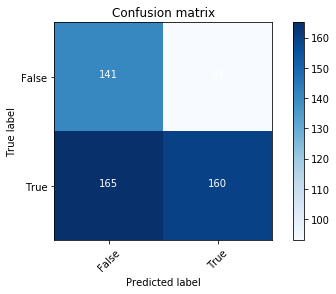

In [124]:
plot_confusion_matrix(cm, data.classes)

# Transfer learning 

In [19]:
data = get_data(sz)

In [20]:
learnTL = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam) 
learnTL.load('299121DENNETRENESNYEN') 
#learnTL.lr_find()
#learnTL.sched.plot()

In [21]:
lr = 0.0001

In [22]:
training(learnTL, lr, 'from_chestx_new1') #husk å endre på denne neste gang! 

epoch      trn_loss   val_loss   accuracy                      
    0      0.514933   0.485745   0.770394  
    1      0.493782   0.444341   0.804488                      
    2      0.467891   0.43573    0.807959                      
    3      0.444363   0.432977   0.812794                      
    4      0.407378   0.417233   0.823085                      
    5      0.400104   0.410591   0.826432                      
    6      0.383989   0.414417   0.827424                      



In [23]:
#den andre

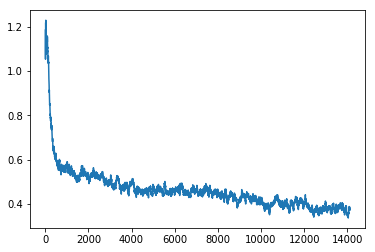

In [40]:
learnTL.sched.plot_loss()

In [24]:
data = get_data(sz)

In [25]:
learnTL1 = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam) 
learnTL1.load('299FORSTE') 

In [26]:
lr = 0.0001

In [27]:
training(learnTL1, lr, 'from_chestx_new2') 

epoch      trn_loss   val_loss   accuracy                      
    0      0.526311   0.483435   0.777957  
    1      0.458238   0.450639   0.802752                      
    2      0.459006   0.444579   0.805232                      
    3      0.457066   0.435539   0.810811                      
    4      0.424088   0.423077   0.816018                      
    5      0.400425   0.41415    0.824076                      
    6      0.379926   0.412776   0.825316                      



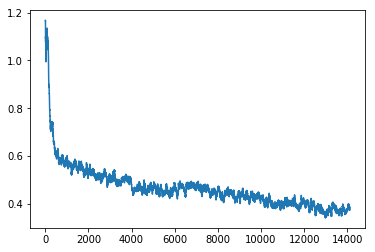

In [41]:
learnTL1.sched.plot_loss()

# From Scratch

In [35]:
data = get_data(sz)

In [36]:
learn_scratch = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam, pretrained = False) 
#learn_scratch.lr_find()
#learn_scratch.sched.plot()

In [37]:
lr = 0.0001

In [38]:
training(learn_scratch, lr, 'from_scratch_new')

  2%|▏         | 49/2017 [00:09<06:16,  5.23it/s, loss=0.9]  

Exception in thread Thread-40:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.765863   0.652541   0.611951  
    1      0.69549    0.645067   0.617282                      
    2      0.692246   0.63191    0.642202                      
    3      0.64113    0.593793   0.680635                      
    4      0.603131   0.582154   0.689437                      
    5      0.595632   0.559522   0.71696                       
    6      0.60018    0.557669   0.71696                       



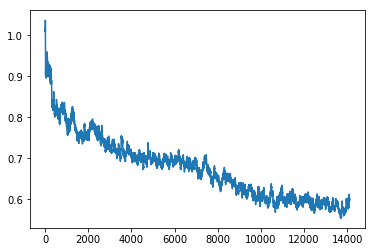

In [39]:
learn_scratch.sched.plot_loss()